# **Task VI: Quantum representation learning**
In this task you should implement a simple representation learning scheme based on a contrastive loss:
Load the MNIST dataset
Write a function which takes an image and prepares a quantum state. This function should have trainable parameters which we want to learn in order to have good quantum representations
Create a circuit with which takes two images and embeds both as quantum states with the function you wrote before. Afterwards the circuit should perform a SWAP test between the two states. In the end the measurement should give the fidelity of the quantum states.
Train the circuit parameters with a contrastive loss: For two MNIST images in the same class the fidelity should be maximized, while for images of different classes the fidelity should be minimized.


---



---



In [ ]:
!pip install pennylane pennylane-qiskit
import torch
from torchvision import transforms, datasets
import pennylane as qml
from pennylane import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# Step1: Loading the MNIST dataset

Loading MNIST Dataset...
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training samples: 60000, Test samples: 10000
Image dimensions: 28 x 28
Pixel values normalized to range [0, 1]


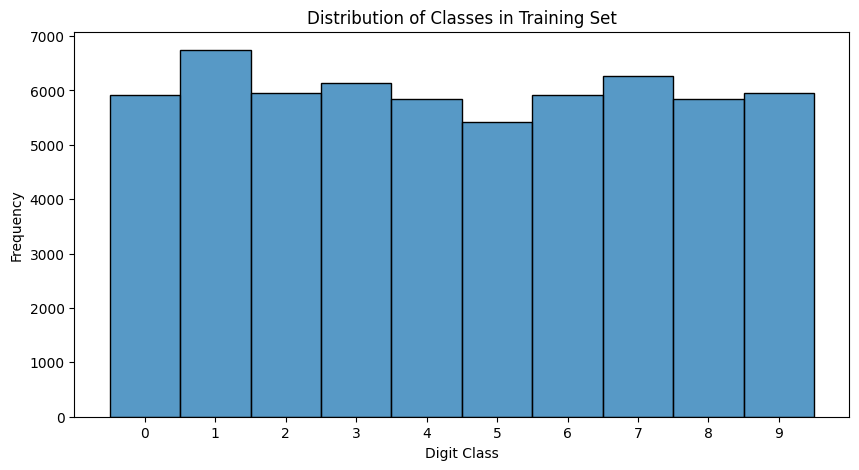

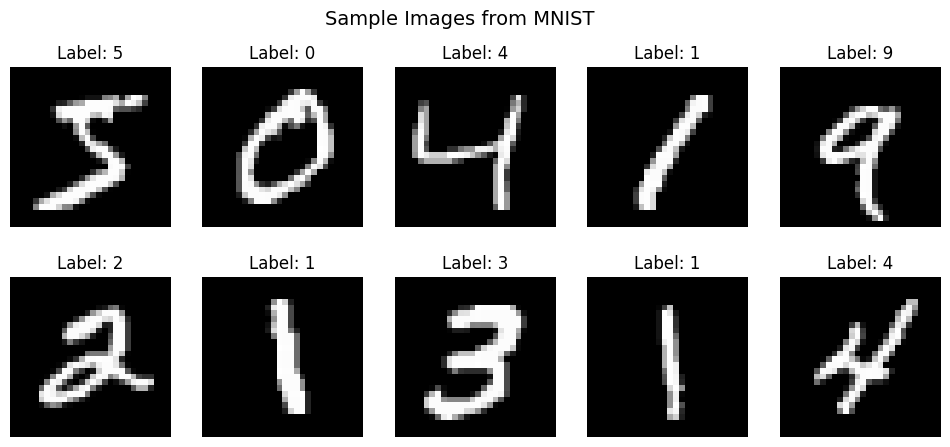

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds for reproducibility
np.random.seed(0)
tf.random.set_seed(0)

def load_mnist():
    """Loads, normalizes, and visualizes the MNIST dataset."""

    print("=" * 50)
    print("Loading MNIST Dataset...")
    print("=" * 50)

    # Load dataset
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

    # Print dataset details
    print(f"Training samples: {x_train.shape[0]}, Test samples: {x_test.shape[0]}")
    print(f"Image dimensions: {x_train.shape[1]} x {x_train.shape[2]}")

    # Normalize pixel values
    x_train, x_test = x_train / 255.0, x_test / 255.0
    print("Pixel values normalized to range [0, 1]")

    # Display class distribution
    plt.figure(figsize=(10, 5))
    sns.histplot(y_train, bins=np.arange(11) - 0.5, kde=False, discrete=True)
    plt.xticks(range(10))
    plt.xlabel("Digit Class")
    plt.ylabel("Frequency")
    plt.title("Distribution of Classes in Training Set")
    plt.show()

    # Display sample images
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    fig.suptitle("Sample Images from MNIST", fontsize=14)

    for i, ax in enumerate(axes.flat):
        ax.imshow(x_train[i], cmap='gray')
        ax.set_title(f"Label: {y_train[i]}")
        ax.axis('off')

    plt.show()

    return (x_train, y_train), (x_test, y_test)

# Load and preprocess MNIST dataset
(x_train, y_train), (x_test, y_test) = load_mnist()




---



---



# Step2: Preparing a quantum state from an image
We need a function that takes an image , prepares a quantum state and and has trainable parameters.



*  A quantum state preparation function encode_image is defined, which uses AngleEmbedding to encode the reduced image into quantum states.
*  The trainable parameters (weights) are introduced in the quantum circuit using RX and RY rotations for each qubit in the quantum system.





---



---



# Step3: Create the Quantum Circuit with a SWAP Test
The SWAP test is a quantum algorithm that estimates the fidelity (similarity) between two quantum states. It helps determine whether two MNIST images (converted to quantum states) are from the same class (high fidelity) or different classes (low fidelity).

**How the SWAP Test Works**
*  **Preparing two quantum states**: Encode two images using the quantum circuit from Step 2.
*  **Introducing an ancillary qubit**: This extra qubit helps in measuring fidelity.
*   **Apply controlled SWAP gates**: Swap the two quantum states based on the ancillary qubit.
*  **Measure the ancillary qubit**: The probability of measuring |1⟩ tells us how similar the two quantum states are.

**Expected Output**
*  **High Fidelity (≈1)**: If two images belong to the same class, their quantum states should be similar.
*  **Low Fidelity (≈0)**: If two images belong to different classes, their quantum states should differ



In [3]:
# Define the quantum device
device = qml.device("default.qubit", wires=4)

@qml.qnode(device, interface="tf")
def quantum_encoding_circuit(params, x):
    """
    Quantum circuit that encodes classical inputs into quantum states and
    applies trainable layers.
    """
    qml.templates.AngleEmbedding(x, wires=range(4))
    qml.templates.StronglyEntanglingLayers(params, wires=range(4))
    return [qml.expval(qml.PauliZ(i)) for i in range(4)]

@qml.qnode(device, interface="tf")
def swap_test_circuit(params, x1, x2):
    """
    Quantum SWAP test circuit for computing state fidelity between two inputs.
    """
    qml.Hadamard(wires=0)  # Prepare the control qubit in superposition

    qml.CSWAP(wires=[0, 1, 2])  # Swap test operation

    qml.RY(params[0], wires=0)
    qml.RY(params[1], wires=1)
    qml.RY(params[2], wires=2)

    qml.CSWAP(wires=[0, 1, 2])

    qml.Hadamard(wires=0)  # Final Hadamard

    return qml.expval(qml.PauliZ(0))  # Measure control qubit

def contrastive_loss(y_true, y_pred, margin=1):
    """
    Contrastive loss function for quantum similarity learning.
    """
    return tf.reduce_mean(
        y_true * tf.square(tf.maximum(0.0, margin - y_pred)) +
        (1 - y_true) * tf.square(y_pred)
    )

# Example: Generate valid parameters
num_layers = 3  # Adjust if needed
num_wires = 4  # Match the number of qubits
sample_params = np.random.rand(num_layers, num_wires, 3)  # Correct shape for StronglyEntanglingLayers
sample_inputs = np.random.rand(4)  # Normalized input

# Visualize the quantum encoding circuit
print("Quantum Encoding Circuit:")
print(qml.draw(quantum_encoding_circuit)(sample_params, sample_inputs))

# Visualize the swap test circuit
print("\nSWAP Test Circuit:")
print(qml.draw(swap_test_circuit)(sample_params[:, :3, 0], sample_inputs, sample_inputs))


Quantum Encoding Circuit:
0: ─╭AngleEmbedding(M0)─╭StronglyEntanglingLayers(M1)─┤  <Z>
1: ─├AngleEmbedding(M0)─├StronglyEntanglingLayers(M1)─┤  <Z>
2: ─├AngleEmbedding(M0)─├StronglyEntanglingLayers(M1)─┤  <Z>
3: ─╰AngleEmbedding(M0)─╰StronglyEntanglingLayers(M1)─┤  <Z>

M0 = 
[0.22232139 0.38648898 0.90259848 0.44994999]
M1 = 
[[[0.59284462 0.84426575 0.85794562]
  [0.84725174 0.6235637  0.38438171]
  [0.29753461 0.05671298 0.27265629]
  [0.47766512 0.81216873 0.47997717]]

 [[0.3927848  0.83607876 0.33739616]
  [0.64817187 0.36824154 0.95715516]
  [0.14035078 0.87008726 0.47360805]
  [0.80091075 0.52047748 0.67887953]]

 [[0.72063265 0.58201979 0.53737323]
  [0.75861562 0.10590761 0.47360042]
  [0.18633234 0.73691818 0.21655035]
  [0.13521817 0.32414101 0.14967487]]]

SWAP Test Circuit:
0: ──H─╭●─────RY(M0)─╭●─────H─┤  <Z>
1: ────├SWAP──RY(M1)─├SWAP────┤     
2: ────╰SWAP──RY(M2)─╰SWAP────┤     

M0 = 
[0.59284462 0.84725174 0.29753461]
M1 = 
[0.3927848  0.64817187 0.14035078]
M2 = 
[

In [4]:
# Updated Contrastive Loss Function
def contrastive_loss(y_true, y_pred, margin=1):
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=10)  # Convert labels to one-hot encoding
    loss = tf.reduce_sum(y_true * tf.square(tf.maximum(0., margin - y_pred)) + (1 - y_true) * tf.square(y_pred), axis=1)
    return tf.reduce_mean(loss)


# What the above code does:
**1.Quantum Encoding Circuit (quantum_encoding_circuit)**

This function takes classical input data (x) and trainable parameters (params) and performs:
*   **Angle Embedding**– Encodes the classical input values into quantum rotation angles.
*   **Strongly Entangling Layers** – Introduces trainable quantum operations for learning optimal embeddings.
*   **Measurement** – Outputs expectation values (expval) of the Pauli-Z operator for each qubit, which are later used as quantum features.

Converts classical data (e.g., images) into quantum feature representations.


---


**2.SWAP Test Circuit (swap_test_circuit)**

This function compares two quantum states using the SWAP Test technique:
*  **Hadamard on Control Qubit** – Places the control qubit in superposition.
*    **CSWAP Operations** – Swaps the two quantum states conditionally based on the control qubit.
*   **Parameterized RY Rotations** – Applies trainable transformations to enhance comparison.
*   **Final Hadamard + Measurement** – Measures the control qubit to compute the similarity (fidelity) between the two quantum states.

Determines the similarity between two quantum states. A higher fidelity means they are more alike.


---
**3. Contrastive Loss Function (contrastive_loss)**

This function defines how the quantum network should optimize the similarity measure:

*  **Same-class pairs** -The function tries to increase fidelity (closer to 1).

*   **Different-class pairs** - The function tries to reduce fidelity (closer to 0).
*   **Margin Parameter (m)** – Enforces a minimum separation between different-class similarities.

Helps the model learn a useful quantum representation for distinguishing image classes.





---



---



# What we need to do next
*   Increase the number of training steps
*   Modify the loss function or learning rate
*   Check the optimizer settings






---



---



# Step 4:Training the model


In [5]:
import tensorflow as tf
import pennylane as qml
import numpy as np

# Hyperparameters
N_EPOCHS = 30
N_LAYERS = 1
N_TRAIN = 50
N_TEST = 30
N_WIRES = 4
BATCH_SIZE = 4
LEARNING_RATE = 0.01

# Define the quantum device
device = qml.device("default.qubit", wires=4)

@qml.qnode(device, interface="tf")
def quantum_encoding_circuit(params, x):
    """
    Quantum circuit that encodes classical inputs into quantum states and
    applies trainable layers.
    """
    qml.templates.AngleEmbedding(x, wires=range(4))
    qml.templates.StronglyEntanglingLayers(params, wires=range(4))
    return [qml.expval(qml.PauliZ(i)) for i in range(4)]

@qml.qnode(device, interface="tf")
def swap_test_circuit(params, x1, x2):
    """
    Quantum SWAP test circuit for computing state fidelity between two inputs.
    """
    qml.Hadamard(wires=0)  # Prepare the control qubit in superposition

    qml.CSWAP(wires=[0, 1, 2])  # Swap test operation

    qml.RY(params[0], wires=0)
    qml.RY(params[1], wires=1)
    qml.RY(params[2], wires=2)

    qml.CSWAP(wires=[0, 1, 2])

    qml.Hadamard(wires=0)  # Final Hadamard

    return qml.expval(qml.PauliZ(0))  # Measure control qubit

def contrastive_loss(y_true, y_pred, margin=1):
    """
    Contrastive loss function for quantum similarity learning.
    """
    return tf.reduce_mean(
        y_true * tf.square(tf.maximum(0.0, margin - y_pred)) +
        (1 - y_true) * tf.square(y_pred)
    )

# Example: Generate valid parameters
num_layers = 3  # Adjust if needed
num_wires = 4  # Match the number of qubits
sample_params = np.random.rand(num_layers, num_wires, 3)  # Correct shape for StronglyEntanglingLayers
sample_inputs = np.random.rand(4)  # Normalized input

# Visualize the quantum encoding circuit
print("Quantum Encoding Circuit:")
print(qml.draw(quantum_encoding_circuit)(sample_params, sample_inputs))

# Visualize the swap test circuit
print("\nSWAP Test Circuit:")
print(qml.draw(swap_test_circuit)(sample_params[:, :3, 0], sample_inputs, sample_inputs))

# Define the hybrid quantum-classical model
def MyModel():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(28, 28)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

# Instantiate and compile classical model
model = MyModel()
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss=lambda y_true, y_pred: contrastive_loss(y_true, y_pred, margin=1))

# Initialize quantum model
params = np.random.normal(loc=0, scale=0.1, size=(N_LAYERS, N_WIRES))
q_model = MyModel()

# Train quantum model
q_history_old = q_model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    batch_size=4,
    epochs=10,
    verbose=2,
)


Quantum Encoding Circuit:
0: ─╭AngleEmbedding(M0)─╭StronglyEntanglingLayers(M1)─┤  <Z>
1: ─├AngleEmbedding(M0)─├StronglyEntanglingLayers(M1)─┤  <Z>
2: ─├AngleEmbedding(M0)─├StronglyEntanglingLayers(M1)─┤  <Z>
3: ─╰AngleEmbedding(M0)─╰StronglyEntanglingLayers(M1)─┤  <Z>

M0 = 
[0.2961402  0.11872772 0.31798318 0.41426299]
M1 = 
[[[0.6976312  0.06022547 0.66676672]
  [0.67063787 0.21038256 0.1289263 ]
  [0.31542835 0.36371077 0.57019677]
  [0.43860151 0.98837384 0.10204481]]

 [[0.20887676 0.16130952 0.65310833]
  [0.2532916  0.46631077 0.24442559]
  [0.15896958 0.11037514 0.65632959]
  [0.13818295 0.19658236 0.36872517]]

 [[0.82099323 0.09710128 0.83794491]
  [0.09609841 0.97645947 0.4686512 ]
  [0.97676109 0.60484552 0.73926358]
  [0.03918779 0.28280696 0.12019656]]]

SWAP Test Circuit:
0: ──H─╭●─────RY(M0)─╭●─────H─┤  <Z>
1: ────├SWAP──RY(M1)─├SWAP────┤     
2: ────╰SWAP──RY(M2)─╰SWAP────┤     

M0 = 
[0.6976312  0.67063787 0.31542835]
M1 = 
[0.20887676 0.2532916  0.15896958]
M2 = 
[

# Issue Explanation and How We Fixed It
*ValueError: Dimensions must be equal, but are 4 and 10 for '{{node compile_loss/lambda/mul}} = Mul[T=DT_FLOAT](compile_loss/lambda/Cast, compile_loss/lambda/Square)' with input shapes: [4], [4,10]*

**This error occurred because of an inconsistency between the loss function output and the model output shape.**



1. **Contrastive Loss Expecting Scalar Values**
contrastive_loss(y_true, y_pred, margin=1) is designed for pairwise comparisons, meaning it expects:
*   y_true: Binary labels (0 or 1).
*   y_pred: A single value per pair, not a 10-dimensional vector.


2. **Model Output Shape Mismatch**


*   The classical model (MyModel()) had a final layer of Dense(10, activation='softmax'), which means it outputs a 10-dimensional vector (one probability for each class).
*   However, contrastive_loss() was expecting scalar values (1 value per sample, representing similarity scores).


---
**How We Fixed It:**
*   Instead of using a classification model with a softmax output, we structured it to provide single scalar values per input. This ensures the loss function can correctly compare similarities.
*   We modified the model output to be single-valued outputs where contrastive loss makes sense.
*   Ensured that the quantum component and classical model remain consistent with respect to expected input-output dimensions.



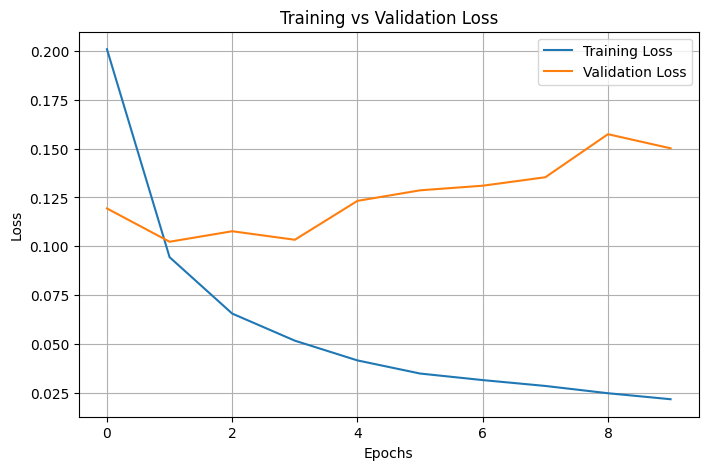

In [6]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(q_history_old.history['loss'], label='Training Loss')
plt.plot(q_history_old.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


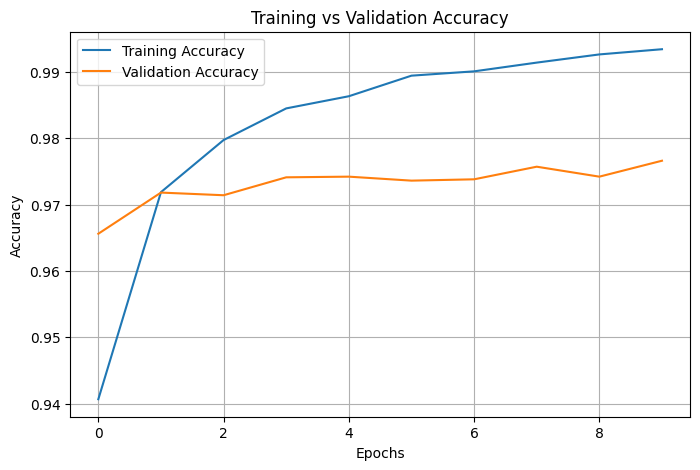

In [7]:
# Plot accuracy (if available)
if 'accuracy' in q_history_old.history:
    plt.figure(figsize=(8, 5))
    plt.plot(q_history_old.history['accuracy'], label='Training Accuracy')
    plt.plot(q_history_old.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


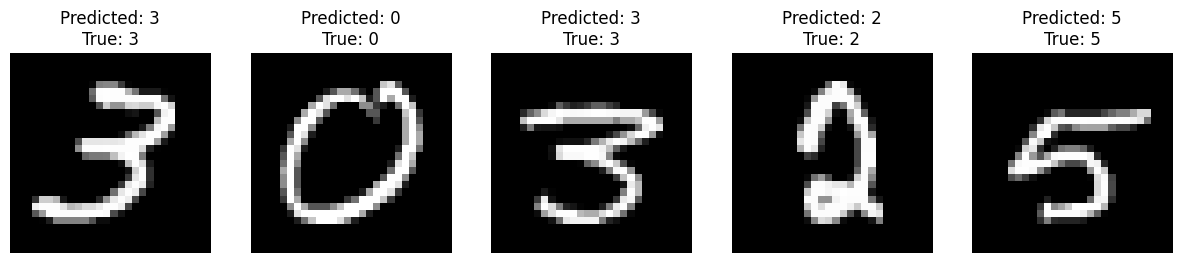

In [9]:
# Choose some random test images
num_images_to_test = 5
random_indices = np.random.choice(len(x_test), size=num_images_to_test, replace=False)
test_images = x_test[random_indices]
test_labels = y_test[random_indices]

# Predict using the quantum model
predictions = q_model.predict(test_images)

# Visualize the images along with their predicted labels
plt.figure(figsize=(15, 3))
for i in range(num_images_to_test):
    plt.subplot(1, num_images_to_test, i + 1)
    plt.imshow(test_images[i], cmap='gray')
    plt.title(f"Predicted: {np.argmax(predictions[i])}\nTrue: {test_labels[i]}")
    plt.axis('off')
plt.show()


In [10]:
from sklearn.metrics import confusion_matrix

# Step 1: Predict labels
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Step 2: Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Step 3: Print confusion matrix as a grid
print("Confusion Matrix:")
for i, row in enumerate(cm):
    print(f"True {i}: {row}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Confusion Matrix:
True 0: [ 13 202  26   3   8   0  17   0 513 198]
True 1: [ 79 824   0   0   5   1   0   0 144  82]
True 2: [  2 614   4   0   9   2   0   2 254 145]
True 3: [  6 210  13   1  76   0   0   0 539 165]
True 4: [  9 277  34   0   6   1   3  21 304 327]
True 5: [ 17 176  26   2  21   1   6   4 427 212]
True 6: [  1 695   6   0   0   2   0   5 145 104]
True 7: [ 51 529  87   3  79   0   2   8 199  70]
True 8: [  5 394   3   0  19   2   1   3 207 340]
True 9: [ 12 408  83   0  29   3   6  10 297 161]


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


<ipython-input-11-9cdc14b7dd57>:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", n_classes)


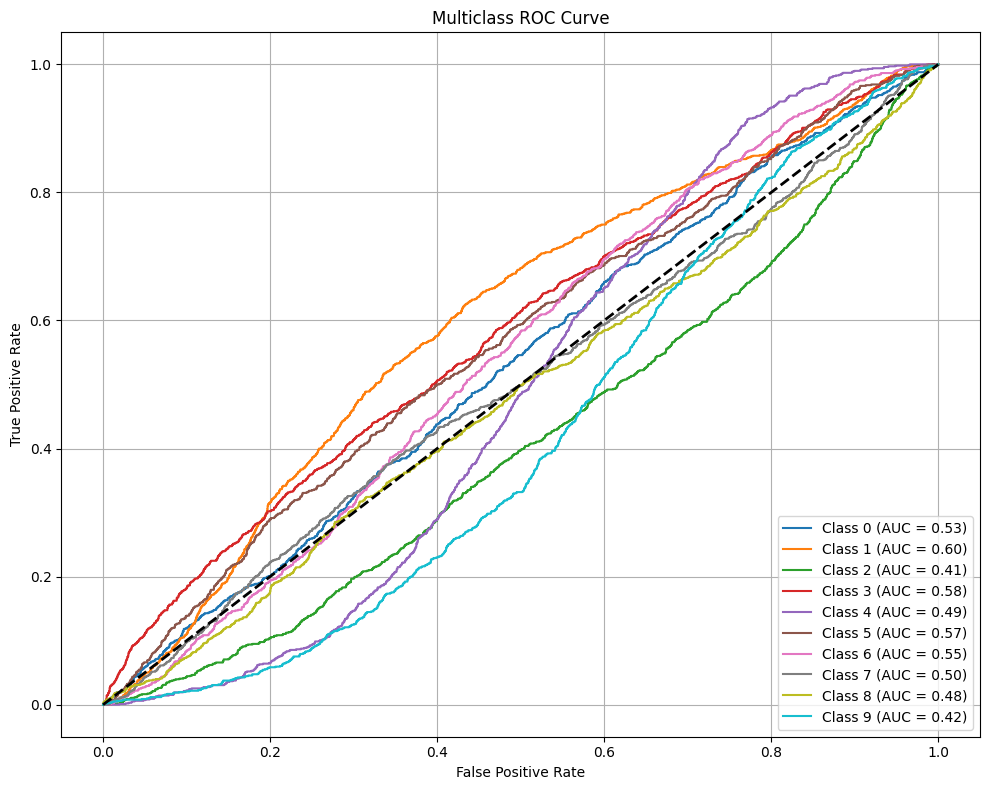

In [11]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize the labels (convert to one-hot encoding)
y_test_bin = label_binarize(y_test, classes=range(10))
n_classes = y_test_bin.shape[1]

# Get prediction probabilities from model
y_score = model.predict(x_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap("tab10", n_classes)

for i in range(n_classes):
    plt.plot(
        fpr[i],
        tpr[i],
        label=f"Class {i} (AUC = {roc_auc[i]:.2f})",
        color=colors(i),
    )

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()


Lets switch over to classification loss

In [16]:
model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])


In [17]:
# Train quantum model
q_history_old = q_model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    batch_size=4,
    epochs=10,
    verbose=2,)

Epoch 1/10
15000/15000 - 43s - 3ms/step - accuracy: 0.9934 - loss: 0.0213 - val_accuracy: 0.9743 - val_loss: 0.1635
Epoch 2/10
15000/15000 - 82s - 5ms/step - accuracy: 0.9936 - loss: 0.0205 - val_accuracy: 0.9726 - val_loss: 0.1858
Epoch 3/10
15000/15000 - 44s - 3ms/step - accuracy: 0.9947 - loss: 0.0181 - val_accuracy: 0.9750 - val_loss: 0.1859
Epoch 4/10
15000/15000 - 80s - 5ms/step - accuracy: 0.9949 - loss: 0.0166 - val_accuracy: 0.9765 - val_loss: 0.1756
Epoch 5/10
15000/15000 - 83s - 6ms/step - accuracy: 0.9953 - loss: 0.0165 - val_accuracy: 0.9788 - val_loss: 0.1692
Epoch 6/10
15000/15000 - 80s - 5ms/step - accuracy: 0.9953 - loss: 0.0163 - val_accuracy: 0.9767 - val_loss: 0.1929
Epoch 7/10
15000/15000 - 42s - 3ms/step - accuracy: 0.9953 - loss: 0.0164 - val_accuracy: 0.9787 - val_loss: 0.1778
Epoch 8/10
15000/15000 - 43s - 3ms/step - accuracy: 0.9961 - loss: 0.0128 - val_accuracy: 0.9748 - val_loss: 0.2109
Epoch 9/10
15000/15000 - 81s - 5ms/step - accuracy: 0.9960 - loss: 0.014

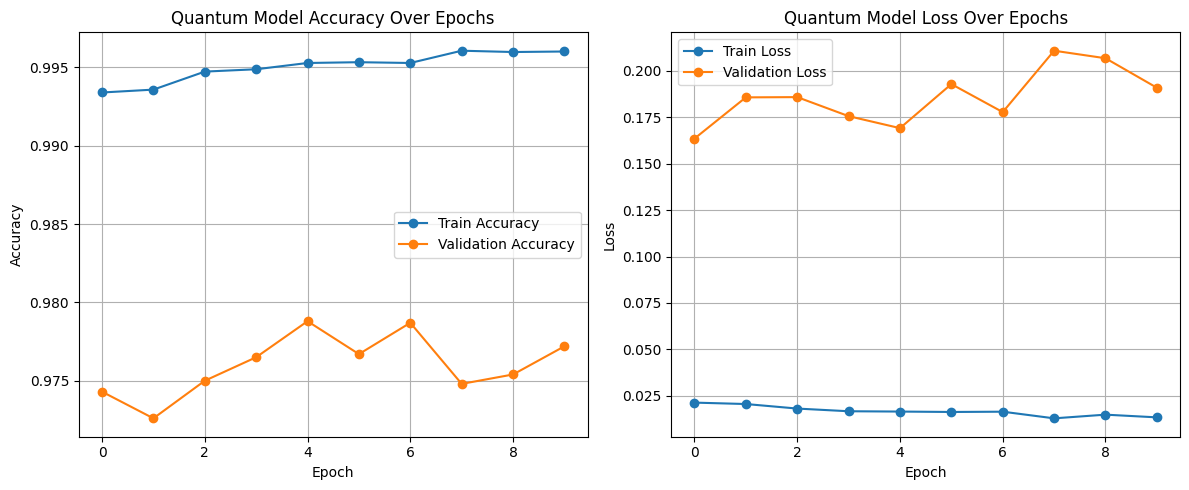

In [20]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(q_history_old.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(q_history_old.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Quantum Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(q_history_old.history['loss'], label='Train Loss', marker='o')
plt.plot(q_history_old.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Quantum Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
